In [48]:
import os
import glob

## Basic data processing and plotting libraries 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from datetime import datetime
from time import time

# Text pipeline and NLP packages

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords  
from nltk.stem.porter import PorterStemmer
import string

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from gensim import corpora, models 
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.models import word2vec  

from pyemd import emd  

# SciKit NMF and LDA package and some easy text data
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE, MDS

from sklearn.linear_model import LinearRegression

In [18]:
## Load raw data
nips_raw = pd.read_excel("nips-papers/abstract2.xlsx")
nips_tmp = pd.read_csv("nips-papers/papers.csv")

In [19]:
## Add year and titles to the clean data and drop row and id 
nips_raw["year"] = nips_tmp["year"]
nips_raw["title"] = nips_tmp["title"]
nips_raw.drop(columns=["row", "id"], inplace = True)

In [20]:
## Drop na values
nips_raw.dropna(inplace=True)
nips_raw.head()

,abstract2,textNoRef,year,title
0,An efficient method of self-organizing associa...,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,1987,Self-Organization of Associative Database and ...
1,A single cell theory for the development of se...,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,1987,A Mean Field Theory of Layer IV of Visual Cort...
2,In modeling studies or memory based on neural...,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,1988,Storing Covariance by the Associative Long-Ter...
3,"If data collection is costly, there is much to...",Bayesian Query Construction for Neural\nNetwor...,1994,Bayesian Query Construction for Neural Network...
4,Learning of continuous valued functions using ...,"Neural Network Ensembles, Cross\nValidation, a...",1994,"Neural Network Ensembles, Cross Validation, an..."


In [21]:
print(nips_raw.shape)
## Sort the df based on publish year 
nips_raw = nips_raw.sort_values(by="year")
nips_raw.reset_index(inplace = True)

## print out the first and last 5 entries 
print("==========================")
print("The first 5 entries:")
print("==========================")
print(nips_raw.head())

print("==========================")
print("The last 5 entries:")
print("==========================")
print(nips_raw.tail())

(7202, 4)
The first 5 entries:
   index                                          abstract2  \
0      0  An efficient method of self-organizing associa...   
1   6190  The complexity and computational capacity of m...   
2   6079  Many connectionist learning models are impleme...   
3   5968  We have developed a neural network which consi...   
4   5857  How does the connectivity of a neural network ...   

                                           textNoRef  year  \
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...  1987   
1  41\n\nON PROPERTIES OF NETWORKS\nOF NEURON-LIK...  1987   
2  348\n\nMinkowski-r Back-Propaaation: Learnine ...  1987   
3  592\n\nA Trellis-Structured Neural Network*\nT...  1987   
4  1\n\nCONNECTIVITY VERSUS ENTROPY\nYaser S. Abu...  1987   

                                               title  
0  Self-Organization of Associative Database and ...  
1  On Properties of Networks of Neuron-Like Elements  
2  Minkowski-r Back-Propagation: Learning in Conn...

In [22]:
## Number of publications per year 
num_papers_per_year = nips_raw["year"].value_counts()
num_papers_per_year

2017    679
2016    569
2014    411
2015    403
2012    368
2013    360
2011    306
2010    292
2009    262
2008    250
2007    217
2004    207
2005    207
2002    206
2006    203
2003    196
2001    196
2000    152
1996    152
1995    151
1998    151
1999    150
1997    150
1993    145
1991    144
1990    142
1994    139
1992    127
1989     97
1988     87
1987     83
Name: year, dtype: int64

In [23]:
# Preprocessing of abstracts and full texts 
# Preprocessed texts are still stored in the dataframe 

## Convert to lowercase
nips_raw.loc[:,'abstract2'] = nips_raw['abstract2'].apply(lambda x: x.lower())
nips_raw.loc[:,'textNoRef'] = nips_raw['textNoRef'].apply(lambda x: x.lower())

## Remove chars that are not letters or numbers
regex = re.compile(r'\W+')
nips_raw.loc[:,'abstract2'] = nips_raw['abstract2'].apply(lambda x: regex.sub(' ',x))
nips_raw.loc[:,'textNoRef'] = nips_raw['textNoRef'].apply(lambda x: regex.sub(' ',x))

## Make a copy and use the copy to make tokens and remove stop words 
## The copy (nips_processed) is only used for counting total number of words for each abstract/paper 
nips_processed = nips_raw.copy()
## Define stopwords 
stops = set(stopwords.words("english")) #stops
stops = stops.union(['I'])
## Initiate tokenizer 
tokenizer = RegexpTokenizer(r'\w+')
## tokenize and remove stopwords 
nips_processed.loc[:,'abstract2'] = nips_processed['abstract2'].apply(lambda x: tokenizer.tokenize(x)) 
nips_processed.loc[:,'abstract2'] = nips_processed['abstract2'].apply(lambda x: [word for word in x if word not in stops]) 
nips_processed.loc[:,'textNoRef'] = nips_processed['textNoRef'].apply(lambda x: tokenizer.tokenize(x)) 
nips_processed.loc[:,'textNoRef'] = nips_processed['textNoRef'].apply(lambda x: [word for word in x if word not in stops])

In [24]:
nips_processed.head()

,index,abstract2,textNoRef,year,title
0,0,"[efficient, method, self, organizing, associat...","[767, self, organization, associative, databas...",1987,Self-Organization of Associative Database and ...
1,6190,"[complexity, computational, capacity, multi, l...","[41, properties, networks, neuron, like, eleme...",1987,On Properties of Networks of Neuron-Like Elements
2,6079,"[many, connectionist, learning, models, implem...","[348, minkowski, r, back, propaaation, learnin...",1987,Minkowski-r Back-Propagation: Learning in Conn...
3,5968,"[developed, neural, network, consists, coopera...","[592, trellis, structured, neural, network, th...",1987,A Trellis-Structured Neural Network
4,5857,"[connectivity, neural, network, number, synaps...","[1, connectivity, versus, entropy, yaser, abu,...",1987,Connectivity Versus Entropy


In [25]:
## Compute the length of each abstract and paper after tokenization and removing stop words 
abstracts_length = nips_processed['abstract2'].apply(lambda x: len(x))
print(abstracts_length.head())
papers_length = nips_processed['textNoRef'].apply(lambda x: len(x))
print(papers_length.head())

0    44
1    89
2    91
3    56
4    50
Name: abstract2, dtype: int64
0    2252
1    3045
2    1551
3    3006
4    1631
Name: textNoRef, dtype: int64


In [49]:
# Function to build tf (raw term count) features from the corpus 
# texts should be lower case corpora with special characters removed

def build_tf(texts, n_features, ngram):
    ## Only extract the top 500 features/words
    stops = set(stopwords.words("english")) 
    stops = stops.union(['I'])
    n_features = 500

    ## Corpus does not work here
    ## Need to supply a list of strings and each string corresponds to a paper 
    print("Extracting tf features...")
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=n_features,
                                    ngram_range = (ngram,ngram),
                                   stop_words = stops)
    t0 = time()
    tf = tf_vectorizer.fit_transform(texts)
    print("done in %0.3fs." % (time() - t0))
    print()

    print("\nThe shape of our count vector matrix: ",tf.shape)
    print(tf_vectorizer.get_feature_names()[:30])
    print("=======================")

    tf_array = tf.toarray()
    return [tf_array, tf_vectorizer.get_feature_names()]

In [50]:
# Build tf (raw term count) features from the corpus 
n_features = 500

## nips_raw should be reused here; 
## tokenization and stop words removal is done using countVectorizer 
abstract_tf_n1 = build_tf(nips_raw['abstract2'], n_features=n_features, ngram=1)
abstract_tf_n2 = build_tf(nips_raw['abstract2'], n_features=n_features, ngram=2)
paper_tf_n1 = build_tf(nips_raw['textNoRef'], n_features=n_features, ngram=1)
paper_tf_n2 = build_tf(nips_raw['textNoRef'], n_features=n_features, ngram=2)

Extracting tf features...
done in 0.806s.


The shape of our count vector matrix:  (7202, 500)
['ability', 'able', 'account', 'accuracy', 'accurate', 'achieve', 'achieved', 'achieves', 'across', 'action', 'actions', 'active', 'activity', 'adaptive', 'addition', 'address', 'algorithm', 'algorithms', 'allows', 'also', 'among', 'analysis', 'analyze', 'application', 'applications', 'applied', 'apply', 'approach', 'approaches', 'approximate']
Extracting tf features...
done in 2.527s.


The shape of our count vector matrix:  (7202, 500)
['active learning', 'address problem', 'algorithm achieves', 'algorithm based', 'algorithm called', 'algorithm learning', 'algorithm uses', 'algorithms based', 'allows us', 'also present', 'also provide', 'also show', 'analysis pca', 'approach based', 'approximate inference', 'approximation error', 'armed bandit', 'art methods', 'art performance', 'art results', 'artificial neural', 'associative memory', 'back propagation', 'based approach', 'based learning',

In [56]:
# Function to compute text length normalized relative frequency of words for each year (per 1000 words)

def relative_frequency_per_year(tf_array, num_papers_per_year, texts_length, years = (1987,2018)):
    ## Iteration of texts and years
    count,n = 0,0
    ## Initiate an empty matrix (year by words)
    tf_norm = np.zeros([num_papers_per_year.shape[0],tf_array.shape[1]])

    ## Iterate over each year and 
    for i in list(range(years[0],years[1])):
        ## Total number of papers for ith year 
        num_papers = num_papers_per_year[i]
        print(f'Current year: {i}')
        print(f'Index of paper to start: {count}')
        print(f'Number of papers in this year: {num_papers}')
        ## subset word tokens from papers for ith year
        tf_tmp = tf_array[count:(count+num_papers),:]
        ## For each article Compute relative frequency of each word
        ## Normalized by length of each article and scaled by 1000
        tf_tmp = tf_tmp / texts_length[count:(count+num_papers),np.newaxis] * 1000
        ## Take the mean of relative frequency of each word across all papers of ith year 
        tf_norm[n,:] = tf_tmp.mean(axis=0)
    
        count = count + num_papers
        n += 1
        print(f'Index of paper to finish: {count}')
        print("=========")
        
    return tf_norm
    


In [58]:
## text length normalized relative frequency of words for single word of abstract
abstract_n1_tf_norm = relative_frequency_per_year(abstract_tf_n1[0], num_papers_per_year, abstracts_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 83
Index of paper to finish: 83
Current year: 1988
Index of paper to start: 83
Number of papers in this year: 87
Index of paper to finish: 170
Current year: 1989
Index of paper to start: 170
Number of papers in this year: 97
Index of paper to finish: 267
Current year: 1990
Index of paper to start: 267
Number of papers in this year: 142
Index of paper to finish: 409
Current year: 1991
Index of paper to start: 409
Number of papers in this year: 144
Index of paper to finish: 553
Current year: 1992
Index of paper to start: 553
Number of papers in this year: 127
Index of paper to finish: 680
Current year: 1993
Index of paper to start: 680
Number of papers in this year: 145
Index of paper to finish: 825
Current year: 1994
Index of paper to start: 825
Number of papers in this year: 139
Index of paper to finish: 964
Current year: 1995
Index of paper to start: 964
Number of papers in this year: 151
Index of paper to fi

In [59]:
## text length normalized relative frequency of words for double words of abstract
abstract_n2_tf_norm = relative_frequency_per_year(abstract_tf_n2[0], num_papers_per_year, abstracts_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 83
Index of paper to finish: 83
Current year: 1988
Index of paper to start: 83
Number of papers in this year: 87
Index of paper to finish: 170
Current year: 1989
Index of paper to start: 170
Number of papers in this year: 97
Index of paper to finish: 267
Current year: 1990
Index of paper to start: 267
Number of papers in this year: 142
Index of paper to finish: 409
Current year: 1991
Index of paper to start: 409
Number of papers in this year: 144
Index of paper to finish: 553
Current year: 1992
Index of paper to start: 553
Number of papers in this year: 127
Index of paper to finish: 680
Current year: 1993
Index of paper to start: 680
Number of papers in this year: 145
Index of paper to finish: 825
Current year: 1994
Index of paper to start: 825
Number of papers in this year: 139
Index of paper to finish: 964
Current year: 1995
Index of paper to start: 964
Number of papers in this year: 151
Index of paper to fi

In [60]:
## text length normalized relative frequency of words for single word of paper
paper_n1_tf_norm = relative_frequency_per_year(paper_tf_n1[0], num_papers_per_year, papers_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 83
Index of paper to finish: 83
Current year: 1988
Index of paper to start: 83
Number of papers in this year: 87
Index of paper to finish: 170
Current year: 1989
Index of paper to start: 170
Number of papers in this year: 97
Index of paper to finish: 267
Current year: 1990
Index of paper to start: 267
Number of papers in this year: 142
Index of paper to finish: 409
Current year: 1991
Index of paper to start: 409
Number of papers in this year: 144
Index of paper to finish: 553
Current year: 1992
Index of paper to start: 553
Number of papers in this year: 127
Index of paper to finish: 680
Current year: 1993
Index of paper to start: 680
Number of papers in this year: 145
Index of paper to finish: 825
Current year: 1994
Index of paper to start: 825
Number of papers in this year: 139
Index of paper to finish: 964
Current year: 1995
Index of paper to start: 964
Number of papers in this year: 151
Index of paper to fi

In [61]:
## text length normalized relative frequency of words for double word of paper
paper_n2_tf_norm = relative_frequency_per_year(paper_tf_n2[0], num_papers_per_year, papers_length, years = (1987,2018))

Current year: 1987
Index of paper to start: 0
Number of papers in this year: 83
Index of paper to finish: 83
Current year: 1988
Index of paper to start: 83
Number of papers in this year: 87
Index of paper to finish: 170
Current year: 1989
Index of paper to start: 170
Number of papers in this year: 97
Index of paper to finish: 267
Current year: 1990
Index of paper to start: 267
Number of papers in this year: 142
Index of paper to finish: 409
Current year: 1991
Index of paper to start: 409
Number of papers in this year: 144
Index of paper to finish: 553
Current year: 1992
Index of paper to start: 553
Number of papers in this year: 127
Index of paper to finish: 680
Current year: 1993
Index of paper to start: 680
Number of papers in this year: 145
Index of paper to finish: 825
Current year: 1994
Index of paper to start: 825
Number of papers in this year: 139
Index of paper to finish: 964
Current year: 1995
Index of paper to start: 964
Number of papers in this year: 151
Index of paper to fi

In [70]:
# Conduct a linear regression for relative frequency of each word as a function of time 
# Store word the R2 and slope of the resulting linear model

def tf_linear_regression(tf_norm, words):
    coef = []
    rsquare = []
    lm = LinearRegression()
    
    ## Iterate over each word and do a linear regression as a function of time
    for i in range(tf_norm.shape[1]):
        x = np.array(list(range(tf_norm.shape[0]))).reshape(-1,1)
        y = tf_norm[:,i].reshape(-1,1)
        lm.fit(x,y)
        rsquare.append(lm.score(x,y))
        coef.append(float(lm.coef_))
    
    ## Make a df out of words, slope and R2 of the linear model for each word
    tmp = np.array([words, coef, rsquare])
    tmp = tmp.T
    term_freq = pd.DataFrame(tmp)
    term_freq.columns = ["word", "coef", "R2"]
    
    ## Adjust data type
    term_freq.coef = term_freq.coef.astype(float)
    term_freq.R2 = term_freq.R2.astype(float)
    
    return (term_freq)
    

In [71]:
abstract_n1_term_freq = tf_linear_regression(tf_norm = abstract_n1_tf_norm, words = abstract_tf_n1[1])
abstract_n2_term_freq = tf_linear_regression(tf_norm = abstract_n2_tf_norm, words = abstract_tf_n2[1])
paper_n1_term_freq = tf_linear_regression(tf_norm = paper_n1_tf_norm, words = paper_tf_n1[1])
paper_n2_term_freq = tf_linear_regression(tf_norm = paper_n2_tf_norm, words = paper_tf_n2[1])

In [78]:
# Function to select words with highest increasing rate of frequency to represent trends

def trend_words(term_freq):
    ## Sort the df by slope and only keep words with R2 > 0.6
    ## Print the first 10 words, which correspond to words with increasing relative frequency over time 
    term_freq2 = term_freq.sort_values(by= ["coef"], ascending=False)
    term_freq2 = term_freq2.loc[term_freq2["R2"] > 0.6,]
    trend_terms = term_freq2.word[:10]
    return(trend_terms)

In [79]:
## Abstract with single word 
abstract_n1_trend_terms = trend_words(abstract_n1_term_freq)
abstract_n1_trend_terms

393          show
203     inference
339       propose
258       methods
330       problem
17     algorithms
87         convex
33            art
95       datasets
250        matrix
Name: word, dtype: object

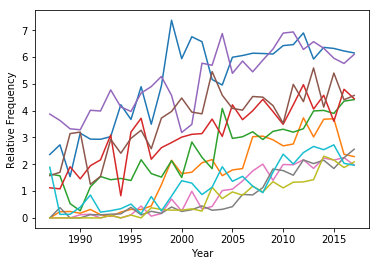

In [113]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n1_tf_norm[:,abstract_n1_trend_terms.index[i]].reshape(-1,1))
    plt.xlabel('Year')
    plt.ylabel('Relative Frequency')
plt.show()

In [99]:
abstract_n1_tf_norm[:,abstract_n1_trend_terms.index[i]][0]

2.3636615080907504

In [103]:
abstract_n1_trend_terms.iloc[0]

'show'

In [80]:
## Abstract with double words
abstract_n2_trend_terms = trend_words(abstract_n2_term_freq)
abstract_n2_trend_terms

448              state art
244       machine learning
171       high dimensional
394             real world
338          paper propose
65     convex optimization
377          propose novel
464         synthetic real
300             non convex
499             worst case
Name: word, dtype: object

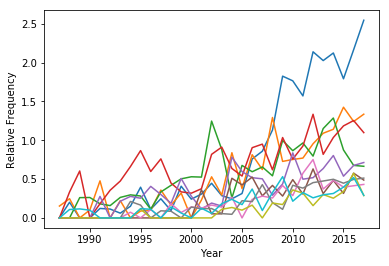

In [110]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             abstract_n2_tf_norm[:,abstract_n2_trend_terms.index[i]].reshape(-1,1))
    plt.xlabel('Year')
    plt.ylabel('Relative Frequency')
plt.show()

In [84]:
## Full text with single word 
paper_n1_trend_terms = trend_words(paper_n1_term_freq)
paper_n1_trend_terms

250             log
34        algorithm
131    distribution
262          matrix
252            loss
60            bound
447         theorem
103          convex
271         methods
212       inference
Name: word, dtype: object

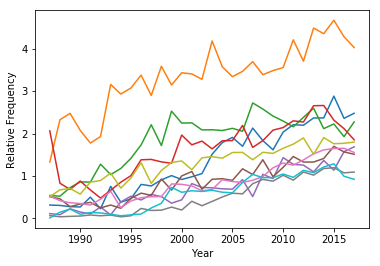

In [111]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             paper_n1_tf_norm[:,paper_n1_trend_terms.index[i]].reshape(-1,1))
    plt.xlabel('Year')
    plt.ylabel('Relative Frequency')
plt.show()

In [86]:
## Full text with double words
paper_n2_trend_terms = trend_words(paper_n2_term_freq)
paper_n2_trend_terms

252          machine learning
242                   log log
249                  low rank
419                 state art
250               lower bound
327      optimization problem
170              ground truth
428    supplementary material
245             loss function
178          high dimensional
Name: word, dtype: object

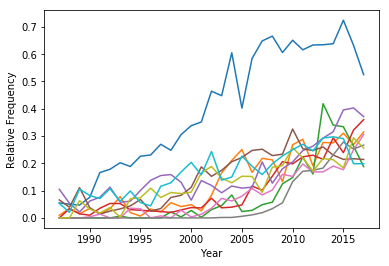

In [112]:
## Plot the frequency of the top 10 words with increasing relative frequency over time 
plt.figure()
for i in range(10):
    plt.plot(np.array(list(range(1987,2018))).reshape(-1,1), 
             paper_n2_tf_norm[:,paper_n2_trend_terms.index[i]].reshape(-1,1))
    plt.xlabel('Year')
    plt.ylabel('Relative Frequency')
plt.show()

In [93]:
## Shared double words between abstract and paper
np.intersect1d(abstract_n2_trend_terms, paper_n2_trend_terms)

array(['high dimensional', 'machine learning', 'state art'], dtype=object)

In [94]:
## Shared single word between abstract and paper
np.intersect1d(abstract_n1_trend_terms, paper_n1_trend_terms)

array(['convex', 'inference', 'matrix', 'methods'], dtype=object)